✍ Давайте применим знания, полученные в предыдущих юнитах, на практике.

В ходе работы мы **подготовим датасет, попробуем несколько видов кластеризации и оценим её качество.**

### 1. Начнём с просмотра датасета:

In [1]:
# импортируем библиотеки для работы с данными
import pandas as pd
from sklearn import preprocessing 

# загрузим данные
df = pd.read_csv("data/segmented_customers.csv")
# посмотрим на данные
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster
0,1,Male,19.0,15.0,39.0,4.0
1,2,Male,21.0,15.0,81.0,3.0
2,3,Female,20.0,16.0,6.0,4.0
3,4,Female,23.0,16.0,77.0,3.0
4,5,Female,31.0,17.0,40.0,4.0


### 2. Проведём предобработку данных: удалим пропуски и дубли, признак Gender превратим в бинарный с помощью LabelEncoder:

In [2]:
# посмотрим, есть ли пропуски в датасете
df[df.isna().any(axis=1)]

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster
200,201,Female,21.0,NaN,40.0,0.0
201,202,Female,30.0,127.0,NaN,NaN
202,203,Male,80.0,NaN,20.0,NaN
203,204,Male,NaN,16.0,120.0,NaN
204,205,Female,NaN,9.0,80.0,NaN


In [3]:
# пропусков не так много, поэтому мы можем удалить данные с пропусками
df = df.dropna()

# переименуем столбцы для более удобной работы
df.rename(columns = {'CustomerID' : 'customer_id', 'Gender' : 'gender', 
                    'Age': 'age', 'Annual Income (k$)': 'annual_income', 
                    'Spending Score (1-100)': 'spending_score', }, inplace = True)

In [4]:
# проверим, есть ли в данных дубликаты
df[df.duplicated(subset=['customer_id'])]

,customer_id,gender,age,annual_income,spending_score,cluster


Дубликатов нет, поэтому идём дальше.

### 3. Чтобы мы могли визуально оценивать результаты кластеризации, будем проводить её по трём признакам, а именно: годовой заработок, коэффициент покупательской способности и возраст. Визуализируем распределение данных:

In [5]:
import plotly
import plotly.express as px

# передаём датафрейм и поля, которые нужно использовать для осей абсцисс, ординат и аппликат
fig = px.scatter_3d(
    data_frame=df, 
    x = 'age', 
    y = 'annual_income', 
    z = 'spending_score', 
    width=1000,
    height=700
)

#отображаем график
fig.show()

### 4. Так как нам часто будет требоваться визуализировать результаты кластеризации, напишем для этого функцию. Она будет принимать датафрейм и название столбца датафрейма с результатами кластеризации. Так как нас будут стабильно интересовать три столбца (age, annual_income, spending_score), зафиксируем их названия внутри функции:

In [7]:
def get_3d_visualization(df, clust_res):
    fig = px.scatter_3d(
        data_frame=df, 
        x = 'age', 
        y = 'annual_income', 
        z = 'spending_score', 
        color = clust_res,
        width=1000,
        height=700
    )

    #возвращаем график
    return fig

### 5. Сохраним признаки, по которым будем проводить моделирование, в переменную X:

In [8]:
X = df[['age', 'annual_income', 'spending_score']]

Как мы видим, данные разрежённые и неоднородные, а значит, применять DBSCAN будет сложно, нужно будет подбирать параметры для кластеризации.

### Задание 10.1

Попробуйте провести DBSCAN-кластеризацию со значениями по умолчанию. Сколько кластеров у вас получилось?

In [19]:
# импортируем DBSCAN кластеризацию
from sklearn.cluster import DBSCAN

#запускаем кластеризацию на наших данных
clustering = DBSCAN().fit(X)

get_3d_visualization(X, clustering.labels_)

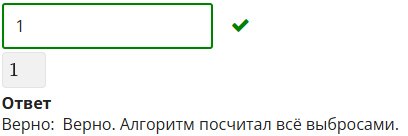

### 6. Как видно, алгоритм плохо работает с настройками по умолчанию, поэтому попробуем изменить их.

Большая часть наших данных разрежённые, а чем больше разброс точек в датасете, тем большее значение радиуса вокруг точки (eps) нужно задавать. Так как данные разрежённые, попробуем увеличить значение eps до 11 и визуально оценим результат:

In [20]:
# импортируем DBSCAN-кластеризацию
from sklearn.cluster import DBSCAN

#запускаем кластеризацию на наших данных
dbscan = DBSCAN(eps=11)
clustering_dbscan_res = dbscan.fit_predict(X)
df['dbscan_res_eps_11'] = clustering_dbscan_res

get_3d_visualization(df, 'dbscan_res_eps_11')

Попробуйте самостоятельно подобрать оптимальное значение eps и min_samples и визуально оценить качество кластеризации.

In [38]:
#запускаем кластеризацию на наших данных
dbscan = DBSCAN(eps=12, min_samples=3)
clustering_dbscan_res = dbscan.fit_predict(X)
df['dbscan_res_eps_11'] = clustering_dbscan_res

get_3d_visualization(df, 'dbscan_res_eps_11')

### Задание 10.2

Подходит ли, по-вашему, алгоритм DBSCAN для решения поставленной задачи?

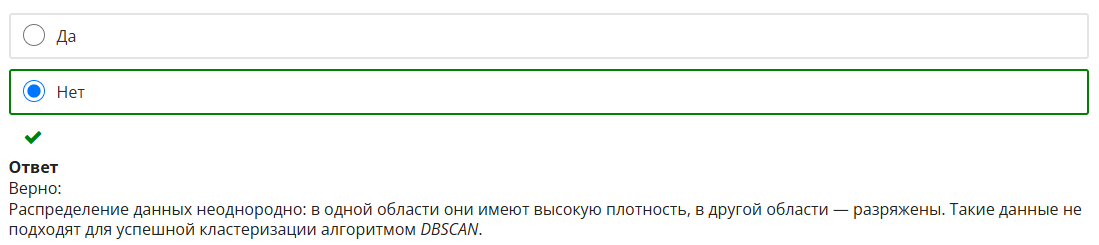

### Задание 10.3

По каким признакам вы оценили качество алгоритма?

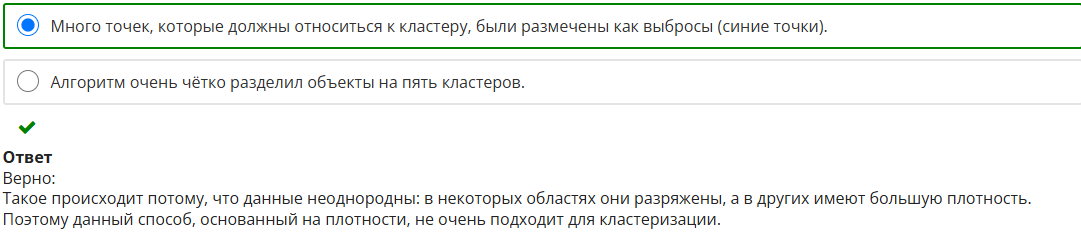

### 7. Проведём агломеративную кластеризацию, чтобы построить дендрограмму и по ней оценить количество кластеров, на которое можно разделить датасет. Напишем функцию, которая будет принимать количество кластеров и матрицу с признаками

In [39]:
# импортируем алгомеративную кластеризацию из sklearn
from sklearn.cluster import AgglomerativeClustering

# напишем функцию, которая будет проводить алгомеративную кластеризацию
# на вход она будет принимать X — матрицу с признаками для кластеризации и n_clusters — количество кластеров,
# на выходе будет возвращать список с номерами кластеров
def get_aggl_clustering(X, n_clusters):
    # запустим агломеративную кластеризацию
    agglomerative_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    # обучим модель агломеративной кластеризации
    agglomerative_clustering.fit(X)
    # получим список c информацией, к какому кластеру относятся объекты
    aggl_prediction = agglomerative_clustering.labels_
    # вернём список с результатами
    return aggl_prediction

### 8. Теперь, вооружившись знаниями из юнита про иерархическую кластеризацию, самостоятельно проведите агломеративную кластеризацию, воспользовавшись функцией, которую мы только что написали. После этого визуализируйте полученную дендрограмму. Количество кластеров для кластеризации укажите равным 3 (на данном этапе это не очень важно).

In [51]:
df['aggl_res_3'] = get_aggl_clustering(X, 3)

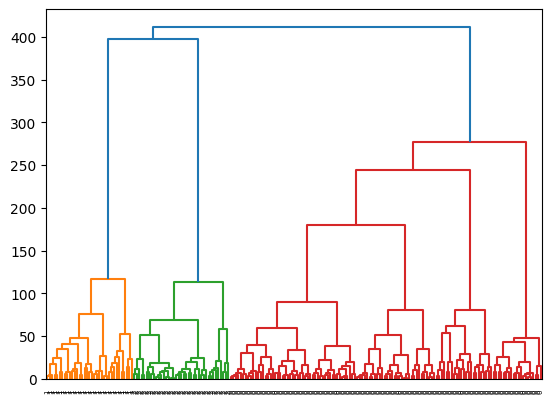

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

linked = linkage(X, 'ward')

dendrogram(linked,
            orientation='top',
            labels=df['aggl_res_3'].to_list(),
            distance_sort='descending',
            show_leaf_counts=True)

plt.show()

In [56]:
import scipy.cluster.hierarchy as sch
help(sch.linkage)

Help on function linkage in module scipy.cluster.hierarchy:

linkage(y, method='single', metric='euclidean', optimal_ordering=False)
    Perform hierarchical/agglomerative clustering.

    The input y may be either a 1-D condensed distance matrix
    or a 2-D array of observation vectors.

    If y is a 1-D condensed distance matrix,
    then y must be a :math:`\binom{n}{2}` sized
    vector, where n is the number of original observations paired
    in the distance matrix. The behavior of this function is very
    similar to the MATLAB linkage function.

    A :math:`(n-1)` by 4 matrix ``Z`` is returned. At the
    :math:`i`-th iteration, clusters with indices ``Z[i, 0]`` and
    ``Z[i, 1]`` are combined to form cluster :math:`n + i`. A
    cluster with an index less than :math:`n` corresponds to one of
    the :math:`n` original observations. The distance between
    clusters ``Z[i, 0]`` and ``Z[i, 1]`` is given by ``Z[i, 2]``. The
    fourth value ``Z[i, 3]`` represents the number of

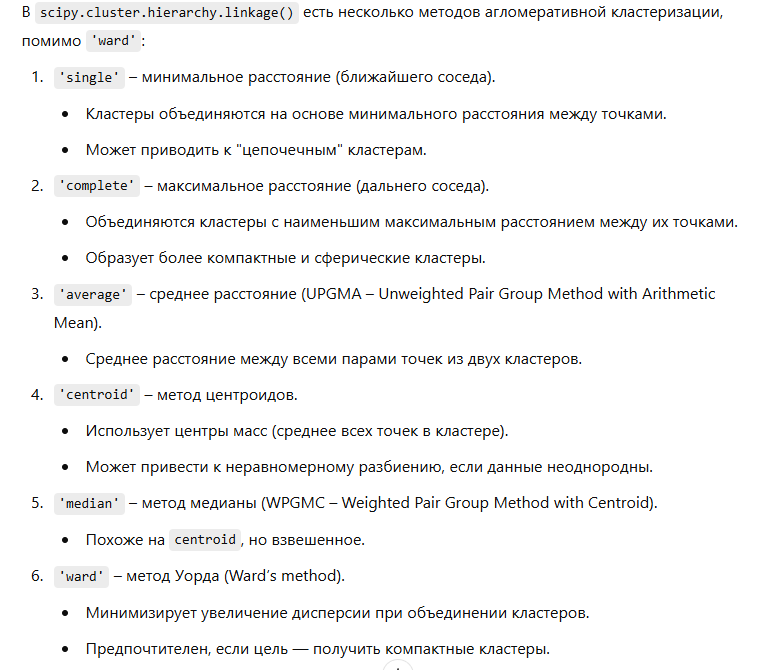

Как мы можем судить из дендрограммы, если взять евклидово расстояние между кластерами, равное 150, датасет будет делиться на **шесть кластеров.**

Давайте визуально оценим, что из этого получилось. Для этого обучим модель агломеративной кластеризации с количеством кластеров, равным 6:

In [57]:
df['aggl_res_6'] = get_aggl_clustering(df[['age', 'annual_income', 'spending_score']], 6)
get_3d_visualization(df, 'aggl_res_6')

Итак, кластеры разделились хорошо.

Теперь давайте воспользуемся коэффициентом силуэта и узнаем оптимальное количество кластеров. Совпадает ли это число с тем, что мы подобрали, используя дендрограмму?

### Задание 10.4

Для агломеративной кластеризации самостоятельно с помощью коэффициента силуэта подберите оптимальное количество кластеров. Сколько кластеров у вас получилось?

<Axes: xlabel='cluster', ylabel='silhouette'>

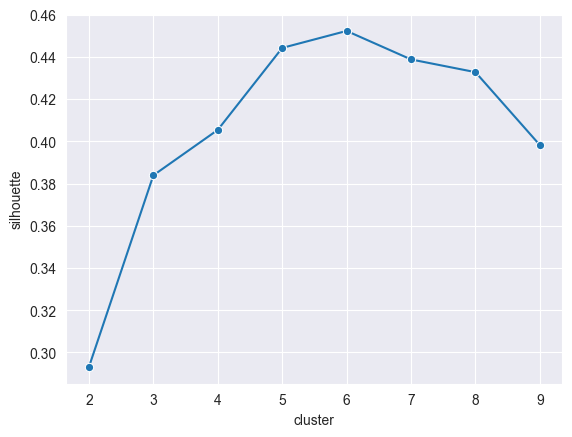

In [59]:
# импортируем метрику силуэт
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans 
import seaborn as sns

# напишем функцию, как и при подсчете метода локтя
def get_silhouette(cluster_num, X):
    k_means =  KMeans(n_clusters=cluster_num, init='k-means++', n_init=10, random_state=42)
    k_means.fit(X)
# подсчитаем метрику силуэта, передав данные и то, к каким кластерам относятся объекты
    silhouette = silhouette_score(X, k_means.predict(X))
    return silhouette

# создадим пустой словарь, ключами будут инерция и количество кластеров
silhouette_res = {"silhouette": [], "cluster": []}


for cluster_num in range(2, 10):
    silhouette_res["silhouette"].append(get_silhouette(cluster_num, X))
    silhouette_res["cluster"].append(cluster_num)
    
# сохраним в датафрейм значение силуэта и количество кластеров
silhouette_df = pd.DataFrame(silhouette_res)

# установим стиль для визуализиции
sns.set_style("darkgrid")
# визуализируем зависимость значения инерции от количества кластеров
sns.lineplot(data=silhouette_df, x="cluster", y="silhouette", marker= "o")

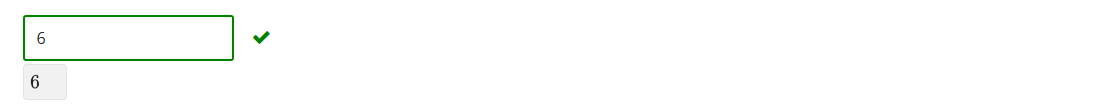

### 8. мтеод силуэта - алгомеративная кластеризация (решение ментора)

<Axes: xlabel='cluster', ylabel='silhouette'>

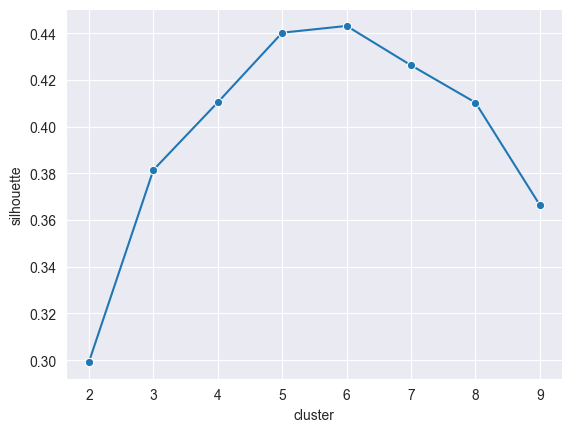

In [60]:
from sklearn.metrics import silhouette_score
import seaborn as sns

# напишем функцию для подсчёта коэффициента силуэта
def get_silhouette_agg_clust(X, cluster_num):
    # проведём агломеративную кластеризацию с заданным количеством кластеров
    res = get_aggl_clustering(X, cluster_num)
    # рассчитаем коэффициент силуэта
    silhouette = silhouette_score(X, res)
    return silhouette


# создадим пустой словарь, ключами будут коэффициент силуэта и количество кластеров
silhouette_res = {"silhouette": [], "cluster": []}


for cluster_num in range(2, 10):
    silhouette_res["silhouette"].append(get_silhouette_agg_clust(X, cluster_num))
    silhouette_res["cluster"].append(cluster_num)

# сохраним в датафрейм значение силуэта и количество кластеров
silhouette_df = pd.DataFrame(silhouette_res)

# установим стиль для визуализиции
sns.set_style("darkgrid")
# визуализируем зависимость значения инерции от количества кластеров
sns.lineplot(data=silhouette_df, x="cluster", y="silhouette", marker="o")

Как видим, пик коэффициента силуэта находится на значении 6. Таким образом, оптимальное количество кластеров — 6.

### 9. Теперь рассмотрим столбец cluster: в нём есть информация о том, к какому кластеру должен принадлежать каждый объект из датасета. Значит, мы можем проверить качество кластеризации, посчитав различные метрики.

### Задание 10.5

Нам очень важно, чтобы в ходе кластеризации не были выделены лишние группы, так как это помешает анализу покупателей. Таким образом, нужно, чтобы кластеры получались максимально наполненными элементами.

Какую метрику вы будете использовать?

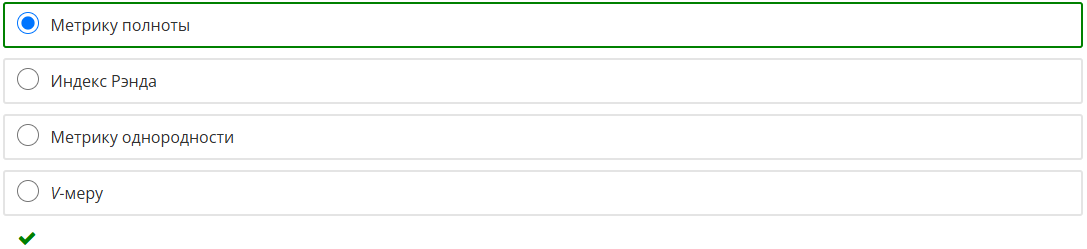

### Метрику полноты можно вызвать из модуля cluster библиотеки sklearn. Метрика рассчитывается следующим образом:

### Полнота

In [61]:
from sklearn.metrics.cluster import completeness_score

print(completeness_score(labels_true=df.cluster, labels_pred=df.aggl_res_6))
# 0.9012847747610448

0.9012847747610448


### V-мера*

In [ ]:
# импортируем из библиотеки sklearn подсчет v-меры
from sklearn.metrics import v_measure_score

# теперь посчитаем v-меру для кластеров с покемонами
print(v_measure_score(labels_true=df.cluster, labels_pred=df.aggl_res_6))


0.8987195524915056


Судя по значению метрики, кластеризация проведена отлично: кластеры получились наполненными элементами, а значит данные результаты можно дальше использовать для анализа.